<a href="https://colab.research.google.com/github/Nohyunjin/DeepLearning/blob/main/Ocular_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import sklearn
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/data/archive/full_df.csv")
df.head(10)

FileNotFoundError: ignored

In [ ]:
# 백내장이 있는 사진인지 구분

def has_cataract(text:str) -> bool:
    if "cataract" in text:
        return 1
    else:
        return 0


# Sequence를 활용한 이미지 증강
# 배치 크기와 이미지 크기를 전역 변수로 선언

BATCH_SIZE = 64
IMAGE_SIZE = 224
dataset_dir = "/content/drive/MyDrive/데이터 사이언스 + R/data/archive/preprocessed_images/"
labels = []
dataset = []

class CnD_Dataset(Sequence):
    
    # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
    def __init__(self, image_filenames, labels, batch_size = BATCH_SIZE, augmentor = None, shuffle = False):

        '''
        파라미터 설명
        image_filenames : openCV로 이미지를 로드할 파일의 절대 경로들
        labels : 해당 image의 label들
        batch_size : __getitem__(self, index) 호출할 때마다 가져올 데이터 batch 건수
        augmentor : ImageGenerator를 적용할 augmentor 설정
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리.
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타남.
    def __len__(self):
        # batch_size 단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 나눠지지 않을 경우 1회를 추가.
        return int(np.ceil(len(self.labels)/self.batch_size))

    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환.
    # 인자로 몇번째 batch 인자를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환.
    # batch_size 갯수만큼 반환된 image_array와 label_array 반환
    def __getitme__(self, index):
        # index는 몇번째 batch인지를 나타냄.
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration 하면서 변환 수행
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmetor가 not None일 경우) -> image_batch에 담음.
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmetor is not None:
                image = self.augmentor(image = image)['image']

            image_batch[image_index] = image

        return image_batch, label_batch

    # epoch가 한번 수행이 완료될 때마다 모델의 fit()에서 호출됨
    def on_epoch_end(self):
        if(self.shuffle):
            # print('epoch end')
            # 전체 image 파일의 위치와 label을 쌍을 맞춰서 섞어준다. scikit learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass


# Sequence 없이 데이터 셋을 만드는 함수
def create_dataset(image_category:str, label:bool):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        except:
            continue

        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,0


In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
print(left_cataract, right_cataract)

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg' '553_left.jpg' '560_left.jpg' '594_left.jpg'
 '611_left.jpg' '625_left.jpg' '629_left.jpg' '691_left.jpg'
 '726_left.jpg' '750_left.jpg' '809_left.jpg' '820_left.jpg'
 '824_left.jpg' '874_left.jpg' '907_left.jpg' '970_left.jpg'
 '999_left.jpg' '1083_left.jpg' '1102_left.jpg' '1115_left.jpg'
 '1144_left.jpg' '1164_left.jpg' '1285_left.jpg' '1415_left.jpg'
 '1435_left.jpg' '1444_left.jpg' '1452_left.jpg' '1468_left.jpg'
 '1483_left.jpg' '1484_left.jpg' '1987_left.jpg' '1994_left.jpg'
 '2052_left.jpg' '2098_left.jpg' '2099_left.jpg' '2101_left.jpg'
 '2102_left.jpg' '2103_left.jpg' '2104_left.jpg' '2105_left.jpg'
 '2108_left.jpg' '2109_left.jpg' '2110_left.jpg' '2111_left.jpg'
 '2113_left.jpg' '2114_left.jpg' '2116_left.jpg' '2117_left.jpg'
 '2120_left.jpg' '2121_left.jpg' '2122_left.jpg' '2123_left.jpg'
 '2124_left.jpg' '2125_left.jpg' '2126

In [ ]:
print(f"Number of images in left cataract: {len(left_cataract)}")
print(f"Number of images in right cataract: {len(right_cataract)}")

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 500


In [ ]:
dataset = create_dataset(cataract, 1)

100%|██████████| 594/594 [00:00<00:00, 3876.99it/s]


In [ ]:
len(dataset)

0

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:00<00:00, 3900.21it/s]


In [ ]:
len(dataset)

0

In [ ]:
np.save('cataract_Ocular_LightSize.npy', dataset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


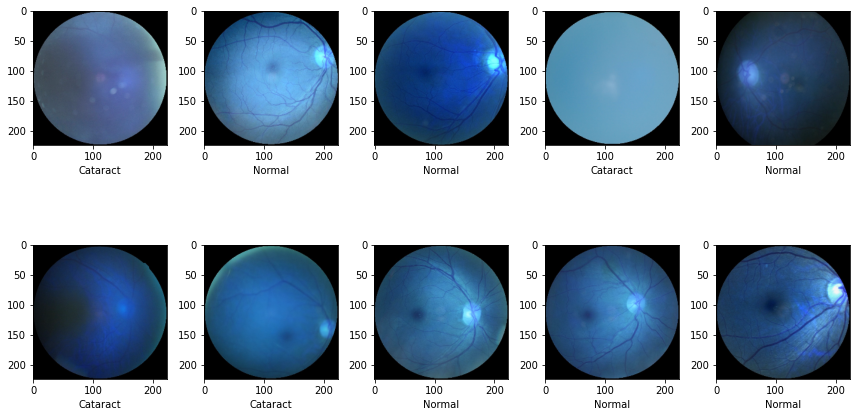

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
y = np.array([i[1] for i in dataset])

In [ ]:
x.shape, y.shape

((1088, 224, 224, 3), (1088,))

In [ ]:
from sklearn.model_selection import train_test_split
train_X , test_X , train_y , test_y = train_test_split(x,y,test_size=0.2)

## ------- Modeling ------

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

NUM_CLASSES = 2


print('train_X shape:', train_X.shape)
print(test_X.shape[0], 'test samples')

input_shape = train_X.shape[1:]

train_X = train_X.astype('float32') / 255
test_X = test_X.astype('float32') / 255

inputs = Input(shape = input_shape)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')
x = conv(inputs)
x = BatchNormalization()(x)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(1e-4))
y = conv(x)
y = BatchNormalization()(y)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', kernel_regularizer = l2(1e-4))
y = conv(y)
y = BatchNormalization()(y)

x = keras.layers.add([x, y])
x = Activation('relu')(x)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(1e-4))
y = conv(x)
y = BatchNormalization()(y)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', kernel_regularizer = l2(1e-4))
y = conv(y)
y = BatchNormalization()(y)

x = keras.layers.add([x, y])
x = Activation('relu')(x)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(1e-4))
y = conv(x)
y = BatchNormalization()(y)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', kernel_regularizer = l2(1e-4))
y = conv(y)
y = BatchNormalization()(y)

x = keras.layers.add([x, y])
x = Activation('relu')(x)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(1e-4))
y = conv(x)
y = BatchNormalization()(y)

conv = Conv2D(filters = 32, kernel_size = 3, padding = 'same', kernel_regularizer = l2(1e-4))
y = conv(y)
y = BatchNormalization()(y)

x = keras.layers.add([x, y])
x = Activation('relu')(x)

x = AveragePooling2D(pool_size = 8)(x)
y = Flatten()(x)

y = Dense(512, activation = 'relu')(y)
outputs = Dense(NUM_CLASSES, activation = 'sigmoid')(y)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

train_X shape: (870, 224, 224, 3)
218 test samples
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 224, 224, 32  128        ['conv2d_9[0][0]']               
 rmalization)                   )        

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

history = model.fit(train_X, train_y, batch_size=64,epochs=100,validation_data=(test_X ,test_y))

Epoch 1/100


ValueError: ignored

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 20,049,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(train_X, train_y, batch_size = 32, epochs = 15,validation_data=(test_X, test_y),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 17s 398ms/step - loss: 1.1962 - accuracy: 0.5184 - val_loss: 0.6927 - val_accuracy: 0.5229
Epoch 2/15
28/28 [==============================] - 7s 255ms/step - loss: 0.6999 - accuracy: 0.5299 - val_loss: 0.6886 - val_accuracy: 0.5229
Epoch 3/15
28/28 [==============================] - 7s 254ms/step - loss: 0.7574 - accuracy: 0.5483 - val_loss: 0.6907 - val_accuracy: 0.5229
Epoch 4/15
28/28 [==============================] - 7s 254ms/step - loss: 0.7643 - accuracy: 0.5034 - val_loss: 0.6916 - val_accuracy: 0.5229
Epoch 5/15
28/28 [==============================] - 7s 254ms/step - loss: 0.7211 - accuracy: 0.4943 - val_loss: 0.7099 - val_accuracy: 0.5229
Epoch 6/15
28/28 [==============================] - 7s 254ms/step - loss: 0.7004 - accuracy: 0.5379 - val_loss: 0.7702 - val_accuracy: 0.4771
Epoch 7/15
28/28 [==============================] - 7s 254ms/step - loss: 0.7060 - accuracy: 0.5046 - val_loss: 0.7025 - val_accuracy: 0.5229
Epoch

In [ ]:
loss,accuracy = model.evaluate(test_X, test_y)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 75ms/step - loss: 0.6982 - accuracy: 0.5229
loss: 0.6982097625732422
Accuracy: 0.5229358077049255
